# DeepBedMap

Predicting the bed elevation of Antarctica using a Super Resolution Deep Neural Network.

In [1]:
import math
import os
import typing

os.environ["CUDA_VISIBLE_DEVICES"] = ""

import comet_ml
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import numpy as np
import pandas as pd
import quilt
import rasterio
import skimage
import xarray as xr

import chainer

from features.environment import _load_ipynb_modules

## Get bounding box of area we want to predict on

In [2]:
def get_image_and_bounds(filepath: str) -> (np.ndarray, rasterio.coords.BoundingBox):
    """
    Retrieve raster image in numpy array format and
    geographic bounds as (xmin, ymin, xmax, ymax)
    """
    with xr.open_dataset(filepath) as data:
        groundtruth = data.z.to_masked_array()
        groundtruth = np.flipud(groundtruth)  # flip on y-axis...
        groundtruth = np.expand_dims(
            np.expand_dims(groundtruth, axis=0), axis=0
        )  # add extra dimensions (batch and channel)
        assert groundtruth.shape[0:2] == (1, 1)  # check that shape is like (1, 1, h, w)

        xmin, xmax = float(data.x.min()), float(data.x.max())
        ymin, ymax = float(data.y.min()), float(data.y.max())

        window_bound = rasterio.coords.BoundingBox(
            left=xmin, bottom=ymin, right=xmax, top=ymax
        )
    return groundtruth, window_bound

In [3]:
test_file = "2007tx"  # "istarxx"
test_filepath = f"highres/{test_file}"
groundtruth, window_bound = get_image_and_bounds(filepath=f"{test_filepath}.nc")

## Get neural network input datasets for our area of interest

In [4]:
def get_deepbedmap_model_inputs(
    window_bound: rasterio.coords.BoundingBox, padding=1000
) -> typing.Dict[str, np.ndarray]:
    """
    Outputs one large tile for each of
    BEDMAP2, REMA and MEASURES Ice Flow Velocity
    according to a given window_bound in the form of
    (xmin, ymin, xmax, ymax).
    """
    data_prep = _load_ipynb_modules("data_prep.ipynb")

    X_tile = data_prep.selective_tile(
        filepath="lowres/bedmap2_bed.tif",
        window_bounds=[[*window_bound]],
        padding=padding,
    )
    W1_tile = data_prep.selective_tile(
        filepath="misc/REMA_100m_dem.tif",
        window_bounds=[[*window_bound]],
        gapfill_raster_filepath="misc/REMA_200m_dem_filled.tif",
        padding=padding,
    )
    W2_tile = data_prep.selective_tile(
        filepath="misc/MEaSUREs_IceFlowSpeed_450m.tif",
        window_bounds=[[*window_bound]],
        out_shape=(2 * X_tile.shape[2], 2 * X_tile.shape[3]),
        padding=padding,
    )

    return X_tile, W1_tile, W2_tile

In [5]:
def plot_3d_view(
    img: np.ndarray,
    ax: matplotlib.axes._subplots.Axes,
    elev: int = 60,
    azim: int = 330,
    cm_norm: matplotlib.colors.Normalize = None,
    title: str = None,
):
    # Get x, y, z data, assuming image in NCHW format
    image = img[0, :, :, :]
    xx, yy = np.mgrid[0 : image.shape[1], 0 : image.shape[2]]
    zz = image[0, :, :]

    # Make the 3D plot
    ax.view_init(elev=elev, azim=azim)
    ax.plot_surface(xx, yy, zz, cmap="BrBG", norm=cm_norm)
    ax.set_title(label=f"{title}\n", fontsize=22)

    return ax

In [6]:
X_tile, W1_tile, W2_tile = get_deepbedmap_model_inputs(window_bound=window_bound)

# Build quilt package for datasets covering our test region
reupload = False
if reupload == True:
    quilt.build(package="weiji14/deepbedmap/model/test/W1_tile", path=W1_tile)
    quilt.build(package="weiji14/deepbedmap/model/test/W2_tile", path=W2_tile)
    quilt.build(package="weiji14/deepbedmap/model/test/X_tile", path=X_tile)
    quilt.push(package="weiji14/deepbedmap/model/test", is_public=True)

Tiling: lowres/bedmap2_bed.tif
Tiling: misc/REMA_100m_dem.tif
Tiling: misc/MEaSUREs_IceFlowSpeed_450m.tif


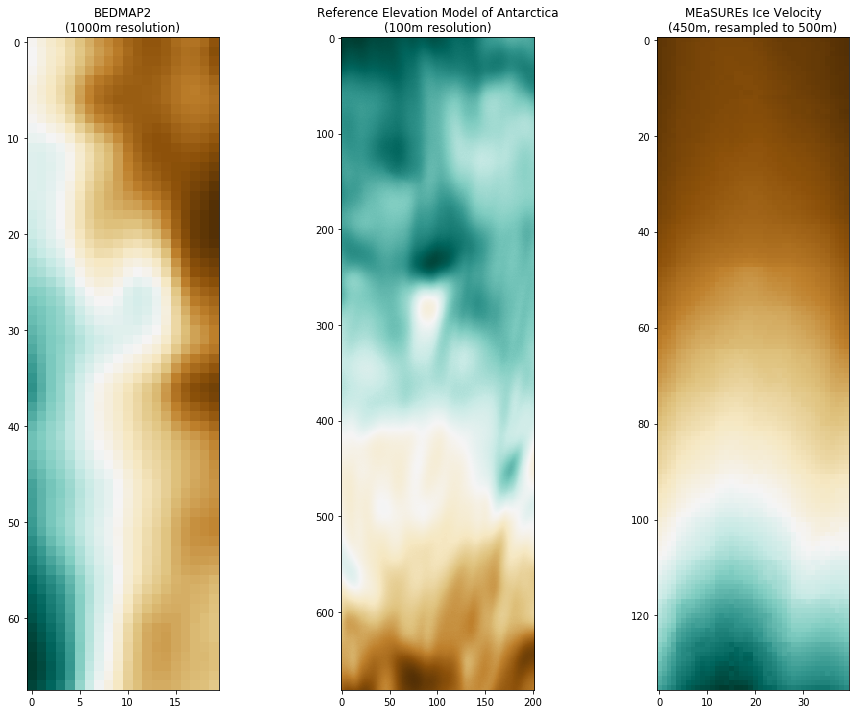

In [7]:
fig, axarr = plt.subplots(nrows=1, ncols=3, squeeze=False, figsize=(16, 12))
axarr[0, 0].imshow(X_tile[0, 0, :, :], cmap="BrBG")
axarr[0, 0].set_title("BEDMAP2\n(1000m resolution)")
axarr[0, 1].imshow(W1_tile[0, 0, :, :], cmap="BrBG")
axarr[0, 1].set_title("Reference Elevation Model of Antarctica\n(100m resolution)")
axarr[0, 2].imshow(W2_tile[0, 0, :, :], cmap="BrBG")
axarr[0, 2].set_title("MEaSUREs Ice Velocity\n(450m, resampled to 500m)")
plt.show()

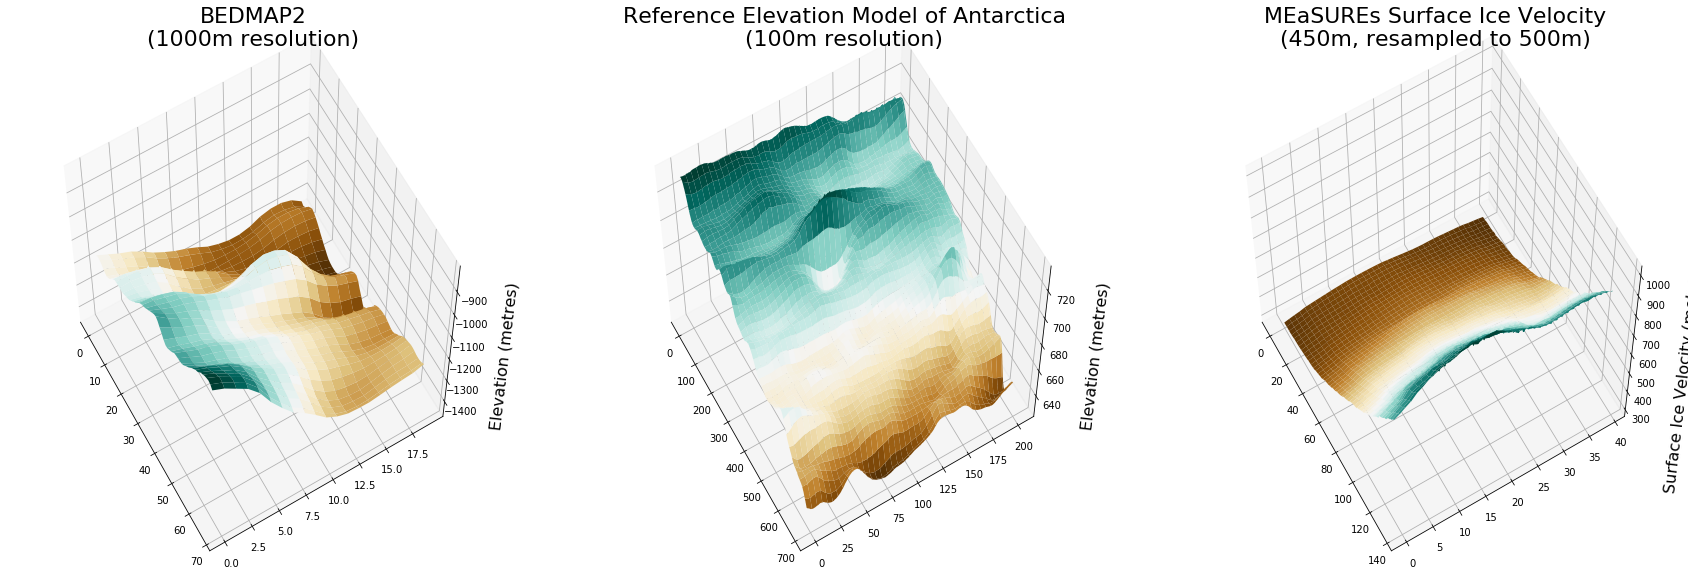

In [8]:
fig = plt.figure(figsize=plt.figaspect(1 / 3) * 2.5)

ax = fig.add_subplot(1, 3, 1, projection="3d")
ax = plot_3d_view(img=X_tile, ax=ax, title="BEDMAP2\n(1000m resolution)")
ax.set_zlabel("\n\nElevation (metres)", fontsize=16)

ax = fig.add_subplot(1, 3, 2, projection="3d")
ax = plot_3d_view(
    img=W1_tile,
    ax=ax,
    title="Reference Elevation Model of Antarctica\n(100m resolution)",
)
ax.set_zlabel("\n\nElevation (metres)", fontsize=16)

ax = fig.add_subplot(1, 3, 3, projection="3d")
ax = plot_3d_view(
    img=W2_tile, ax=ax, title="MEaSUREs Surface Ice Velocity\n(450m, resampled to 500m)"
)
ax.set_zlabel("\n\nSurface Ice Velocity (metres/year)", fontsize=16)

plt.show()

## Create custom neural network for our area of interest

Fully convolutional networks rock!!
Since we have a fully convolutional model architecture,
we can change the shape of the inputs/outputs,
but use the same trained weights!
That way we can predict directly on an arbitrarily sized window.

In [9]:
def load_trained_model(
    model=None,
    model_weights_path: str = "model/weights/srgan_generator_model_weights.npz",
):
    """
    Builds the Generator component of the DeepBedMap neural network.
    Also loads trained parameter weights into the model from a .npz file.
    """
    srgan_train = _load_ipynb_modules("srgan_train.ipynb")

    if model is None:
        model = srgan_train.GeneratorModel()

    # Load trained neural network weights into model
    chainer.serializers.load_npz(file=model_weights_path, obj=model)

    return model

## Make prediction

In [10]:
model = load_trained_model()
Y_hat = model.forward(x=X_tile, w1=W1_tile, w2=W2_tile).array
Y_hat.shape

(1, 1, 264, 72)

## Plot results

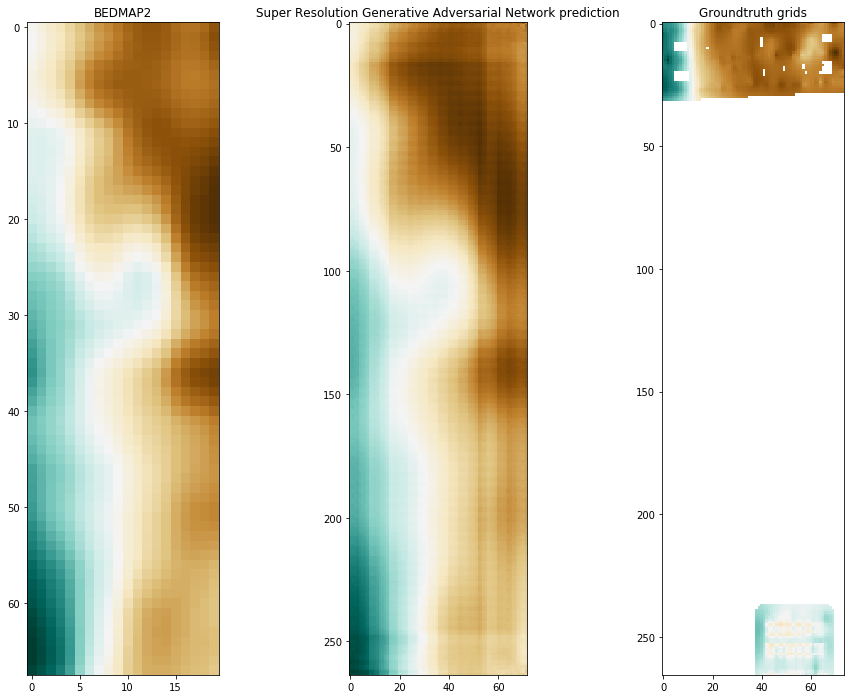

In [11]:
fig, axarr = plt.subplots(nrows=1, ncols=3, squeeze=False, figsize=(16, 12))
axarr[0, 0].imshow(X_tile[0, 0, :, :], cmap="BrBG")
axarr[0, 0].set_title("BEDMAP2")
axarr[0, 1].imshow(Y_hat[0, 0, :, :], cmap="BrBG")
axarr[0, 1].set_title("Super Resolution Generative Adversarial Network prediction")
axarr[0, 2].imshow(groundtruth[0, 0, :, :], cmap="BrBG")
axarr[0, 2].set_title("Groundtruth grids")
plt.show()

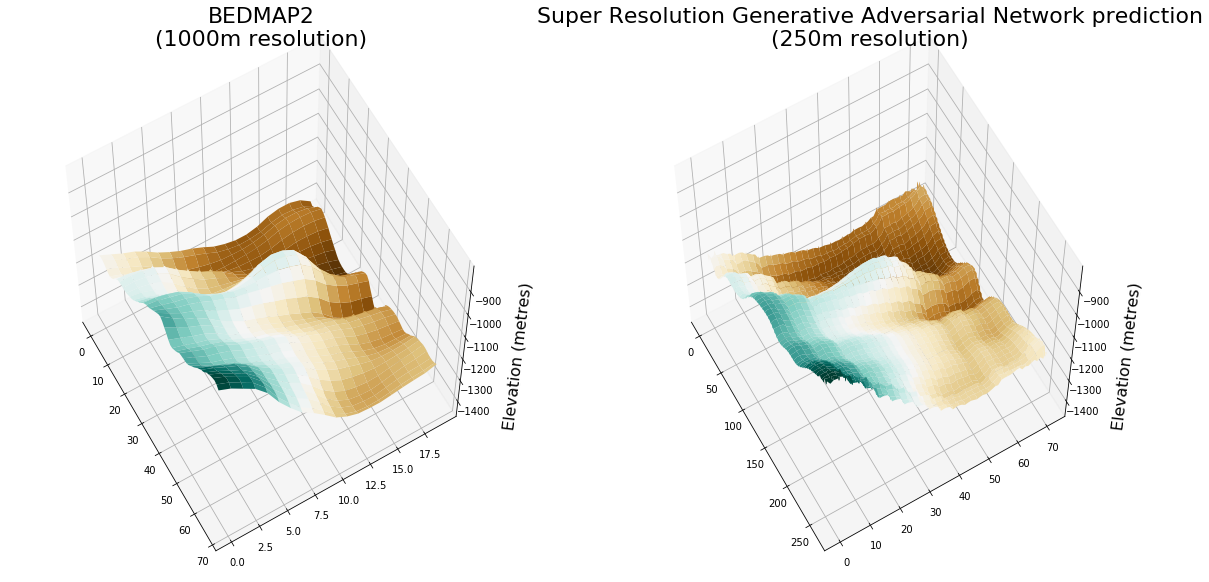

In [12]:
fig = plt.figure(figsize=plt.figaspect(1 / 2) * 2.5)

zmin, zmax = (X_tile.min(), X_tile.max())
norm_Z = matplotlib.cm.colors.Normalize(vmin=zmin, vmax=zmax)

ax = fig.add_subplot(1, 2, 1, projection="3d")
ax = plot_3d_view(
    img=X_tile, ax=ax, cm_norm=norm_Z, title="BEDMAP2\n(1000m resolution)"
)
ax.set_zlim(bottom=zmin, top=zmax)
ax.set_zlabel("\n\nElevation (metres)", fontsize=16)

ax = fig.add_subplot(1, 2, 2, projection="3d")
ax = plot_3d_view(
    img=Y_hat,
    ax=ax,
    cm_norm=norm_Z,
    title="Super Resolution Generative Adversarial Network prediction\n(250m resolution)",
)
ax.set_zlim(bottom=zmin, top=zmax)
ax.set_zlabel("\n\nElevation (metres)", fontsize=16)

plt.show()

# Save Bicubic BEDMAP2 and SRGAN DEEPBEDMAP to a grid file

In [13]:
def save_array_to_grid(window_bound: tuple, array: np.ndarray, outfilepath: str):
    """
    Saves a numpy array to geotiff and netcdf format.
    Appends ".tif" and ".nc" file extension to the outfilepath
    for geotiff and netcdf outputs respectively.
    """

    assert array.ndim == 4
    assert array.shape[1] == 1  # check that there is only one channel

    transform = rasterio.transform.from_bounds(
        *window_bound, height=array.shape[2], width=array.shape[3]
    )

    # Save array as a GeoTiff first
    with rasterio.open(
        f"{outfilepath}.tif",
        mode="w",
        driver="GTiff",
        height=array.shape[2],
        width=array.shape[3],
        count=1,
        crs="EPSG:3031",
        transform=transform,
        dtype=array.dtype,
    ) as new_geotiff:
        new_geotiff.write(array[0, 0, :, :], 1)

    # Convert deepbedmap3 and cubicbedmap2 from geotiff to netcdf format
    xr.open_rasterio(f"{outfilepath}.tif").to_netcdf(f"{outfilepath}.nc")

In [14]:
# Save BEDMAP3 to GeoTiff and NetCDF format
save_array_to_grid(
    window_bound=window_bound, array=Y_hat, outfilepath="model/deepbedmap3"
)

In [15]:
# Save Bicubic Resampled BEDMAP2 to GeoTiff and NetCDF format
cubicbedmap2 = skimage.transform.rescale(
    image=X_tile[0, 0, :, :].astype(np.int32),
    scale=4,  # 4x upscaling
    order=3,  # cubic interpolation
    mode="reflect",
    anti_aliasing=True,
    multichannel=False,
    preserve_range=True,
)
save_array_to_grid(
    window_bound=window_bound,
    array=np.expand_dims(np.expand_dims(cubicbedmap2, axis=0), axis=0),
    outfilepath="model/cubicbedmap",
)

# Crossover analysis

We use [grdtrack](https://gmt.soest.hawaii.edu/doc/latest/grdtrack) to sample our grid along the survey tracks.

The survey tracks are basically geographic xy points flown by a plane.
The three grids are all 250m spatial resolution, and they are:

- Groundtruth grid (interpolated from our groundtruth points using [surface](https://gmt.soest.hawaii.edu/doc/latest/surface.html))
- DeepBedMap3 grid (predicted from our [Super Resolution Generative Adversarial Network model](/srgan_train.ipynb))
- CubicBedMap grid (interpolated from BEDMAP2 using a [bicubic spline algorithm](http://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.rescale))

Reference:

Wessel, P. (2010). Tools for analyzing intersecting tracks: The x2sys package. Computers & Geosciences, 36(3), 348–354. https://doi.org/10.1016/j.cageo.2009.05.009

In [16]:
data_prep = _load_ipynb_modules("data_prep.ipynb")
track_test = data_prep.ascii_to_xyz(pipeline_file=f"{test_filepath}.json")
track_test.to_csv("track_test.xyz", sep="\t", index=False)

In [17]:
!gmt grdtrack track_test.xyz -G{test_filepath}.nc -h1 -i0,1,2 > track_groundtruth.xyzi
!gmt grdtrack track_test.xyz -Gmodel/deepbedmap3.nc -h1 -i0,1,2 > track_deepbedmap3.xyzi
!gmt grdtrack track_test.xyz -Gmodel/cubicbedmap.nc -h1 -i0,1,2 > track_cubicbedmap.xyzi
!head track_*.xyzi -n5

==> track_cubicbedmap.xyzi <==
# x	y	z
-1593496.33	-104797.8003	-1074.669904	-1154.50380205
-1593491.331	-104797.7531	-1074.68	-1154.42776538
-1593486.331	-104797.7058	-1074.683558	-1154.35249079
-1593481.331	-104797.6599	-1074.695031	-1154.27806665

==> track_deepbedmap3.xyzi <==
# x	y	z
-1593496.33	-104797.8003	-1074.669904	-1152.80060477
-1593491.331	-104797.7531	-1074.68	-1152.63822122
-1593486.331	-104797.7058	-1074.683558	-1152.47877832
-1593481.331	-104797.6599	-1074.695031	-1152.32247008

==> track_groundtruth.xyzi <==
# x	y	z
-1593496.33	-104797.8003	-1074.669904	-1076.93163393
-1593491.331	-104797.7531	-1074.68	-1077.02038288
-1593486.331	-104797.7058	-1074.683558	-1077.11179311
-1593481.331	-104797.6599	-1074.695031	-1077.20604871


### Get table statistics

In [18]:
names = ["x", "y", "z", "z_interpolated"]
df_groundtruth = pd.read_csv("track_groundtruth.xyzi", sep="\t", header=1, names=names)
df_deepbedmap3 = pd.read_csv("track_deepbedmap3.xyzi", sep="\t", header=1, names=names)
df_cubicbedmap = pd.read_csv("track_cubicbedmap.xyzi", sep="\t", header=1, names=names)

In [19]:
df_groundtruth["error"] = df_groundtruth.z_interpolated - df_groundtruth.z
df_groundtruth.describe()

,x,y,z,z_interpolated,error
count,4.251900e+04,42519.000000,42519.000000,42519.000000,42519.000000
mean,-1.582757e+06,-127325.264835,-1254.856877,-1255.085246,-0.228368
std,4.508689e+03,29482.513828,75.079124,74.385125,7.314787
min,-1.593714e+06,-164173.784800,-1390.940804,-1382.213580,-112.671590
25%,-1.585651e+06,-160928.278350,-1327.666236,-1327.409421,-1.765492
50%,-1.581923e+06,-104330.745000,-1251.150818,-1246.127694,-0.061275
75%,-1.579367e+06,-101358.125200,-1195.045000,-1196.828030,1.379292
max,-1.575464e+06,-97923.920590,-962.574500,-1045.562709,46.403994


In [20]:
df_deepbedmap3["error"] = df_deepbedmap3.z_interpolated - df_deepbedmap3.z
df_deepbedmap3.describe()

,x,y,z,z_interpolated,error
count,4.009500e+04,40095.000000,40095.000000,40095.000000,40095.000000
mean,-1.582823e+06,-127943.948452,-1255.901352,-1289.989948,-34.088597
std,4.306205e+03,29434.912966,73.216368,73.979983,31.563624
min,-1.593587e+06,-164048.233300,-1390.940804,-1415.578013,-194.747482
25%,-1.585696e+06,-160901.037700,-1327.500988,-1363.089763,-56.357401
50%,-1.582073e+06,-104396.422700,-1250.925200,-1255.009328,-37.999973
75%,-1.579456e+06,-101515.335350,-1195.214216,-1228.917877,-12.609497
max,-1.575591e+06,-98049.505510,-962.574500,-1132.775027,107.752237


In [21]:
df_cubicbedmap["error"] = df_cubicbedmap.z_interpolated - df_cubicbedmap.z
df_cubicbedmap.describe()

,x,y,z,z_interpolated,error
count,4.003100e+04,40031.000000,40031.000000,40031.000000,40031.000000
mean,-1.582937e+06,-126647.148224,-1254.989995,-1299.432762,-44.442768
std,4.565391e+03,29170.154478,75.775107,59.021202,43.573560
min,-1.593714e+06,-163928.941600,-1390.940804,-1388.976847,-179.727581
25%,-1.586045e+06,-160292.153750,-1327.932451,-1349.923849,-82.959801
50%,-1.582303e+06,-104305.511300,-1254.730000,-1291.975838,-47.598728
75%,-1.579429e+06,-101422.144400,-1194.651881,-1271.833734,-21.154374
max,-1.575464e+06,-98167.517730,-962.574500,-1138.908560,75.846243


Difference      : -15.78


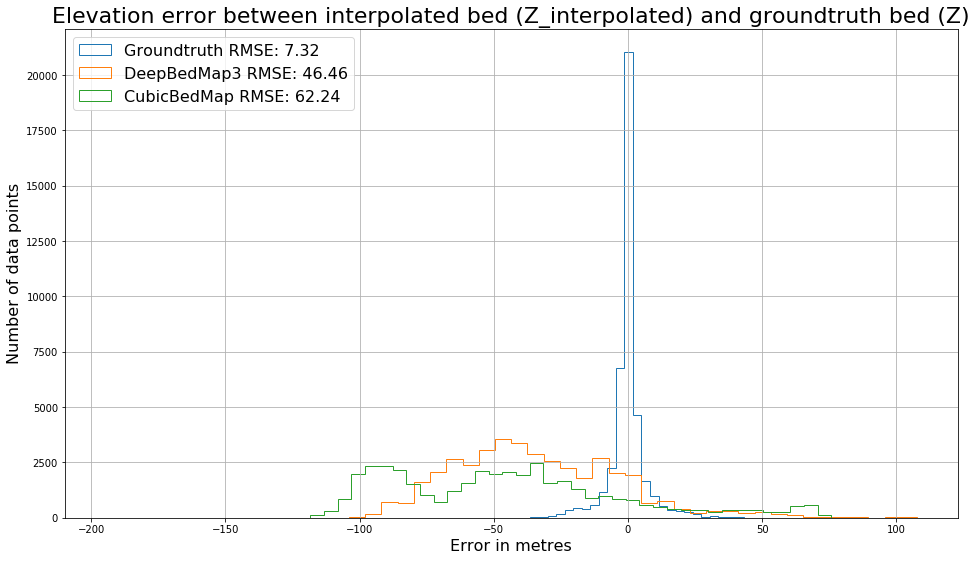

In [22]:
# https://medium.com/usf-msds/choosing-the-right-metric-for-machine-learning-models-part-1-a99d7d7414e4
rmse_groundtruth = (df_groundtruth.error ** 2).mean() ** 0.5
rmse_deepbedmap3 = (df_deepbedmap3.error ** 2).mean() ** 0.5
rmse_cubicbedmap = (df_cubicbedmap.error ** 2).mean() ** 0.5
print(f"Difference      : {rmse_deepbedmap3 - rmse_cubicbedmap:.2f}")

fig, ax = plt.subplots(figsize=(16, 9))
df_groundtruth.hist(
    column="error",
    bins=50,
    ax=ax,
    histtype="step",
    label=f"Groundtruth RMSE: {rmse_groundtruth:.2f}",
)
df_deepbedmap3.hist(
    column="error",
    bins=50,
    ax=ax,
    histtype="step",
    label=f"DeepBedMap3 RMSE: {rmse_deepbedmap3:.2f}",
)
df_cubicbedmap.hist(
    column="error",
    bins=50,
    ax=ax,
    histtype="step",
    label=f"CubicBedMap RMSE: {rmse_cubicbedmap:.2f}",
)
ax.set_title(
    "Elevation error between interpolated bed (Z_interpolated) and groundtruth bed (Z)",
    fontsize=22,
)
ax.set_xlabel("Error in metres", fontsize=16)
ax.set_ylabel("Number of data points", fontsize=16)
ax.legend(loc="upper left", fontsize=16)
plt.show()

In [23]:
# https://medium.com/usf-msds/choosing-the-right-metric-for-machine-learning-models-part-1-a99d7d7414e4
rmse_groundtruth = (df_groundtruth.error ** 2).mean() ** 0.5
rmse_deepbedmap3 = (df_deepbedmap3.error ** 2).mean() ** 0.5
rmse_cubicbedmap = (df_cubicbedmap.error ** 2).mean() ** 0.5
print(f"Groundtruth RMSE: {rmse_groundtruth}")
print(f"DeepBedMap3 RMSE: {rmse_deepbedmap3}")
print(f"CubicBedMap RMSE: {rmse_cubicbedmap}")
print(f"Difference      : {rmse_deepbedmap3 - rmse_cubicbedmap}")

Groundtruth RMSE: 7.318264583382579
DeepBedMap3 RMSE: 46.45718387942379
CubicBedMap RMSE: 62.23959615794133
Difference      : -15.78241227851754
